In [35]:
import os
import glob
import tqdm
import random
import numpy as np
import face_recognition
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
torch.manual_seed(123)

# Evaluation

In [5]:
def face_recog(image_dir):
    image_ids = os.listdir(image_dir)
    total_faces = len(image_ids)
    num_faces = 0
    # print("Start face recognition...")
    for image_id in tqdm.tqdm(image_ids):
        image_path = os.path.join(image_dir, image_id)
        try: # Prevent unexpected file
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image, model="HOG")
            if len(face_locations) == 1:
                num_faces += 1
        except:
            total_faces -= 1
    acc = (num_faces / total_faces) * 100
    return acc

# Visualization

In [6]:
def imageshow(image):
    """ show the image of a sample """
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xticks([])
    ax.set_yticks([])
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    # reshape the img from (3, 32, 32) to (32, 32, 3)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

In [7]:
def batchshow(dataloader):
    """ show the images of a batch of sample """
    for images in dataloader:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_xticks([])
        ax.set_yticks([])
        for image in images:
            for t, m, s in zip(image, mean, std):
                t.mul_(s).add_(m)
        # reshape the img from (3, 32, 32) to (32, 32, 3)
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break

In [8]:
def fakeshow(fake_images):
    """ show the fake images """
    if len(fake_images) == 1:
        fake_images = fake_images.squeeze()
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(fake_images.permute(1, 2, 0))
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xticks([])
        ax.set_yticks([])
        # reshape the img from (3, 32, 32) to (32, 32, 3)
        ax.imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))
        plt.show()

# Custom Dataset & DataLoader

In [9]:
class HW2P1(Dataset):
    def __init__(self, dirpath, transform=None):
        """ Initialize custom dataset """
        self.filepaths = []
        self.transform = transform

        # get all image names
        for fp in glob.glob(dirpath + '/*.png'):
            self.filepaths.append(fp)
    
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        fp = self.filepaths[index]
        image = Image.open(fp)

        if self.transform is not None:
            image = self.transform(image)
        image.unsqueeze(0)

        return image
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.filepaths)

In [10]:
trainset = HW2P1(
    dirpath='./hw2_data/face/train/',
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

In [11]:
print("# of images in trainset: ", len(trainset))

# of images in trainset:  38464


In [12]:
dataloaders = {
    'train': DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4),
}

In [13]:
dataiter = iter(dataloaders['train'])
images = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)

Image tensor in each batch: torch.Size([128, 3, 64, 64]) torch.float32


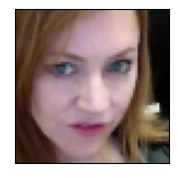

In [14]:
for i in range(1):
  sample = dataloaders['train'].dataset[random.randint(0, len(dataloaders['train']))]
  imageshow(sample)

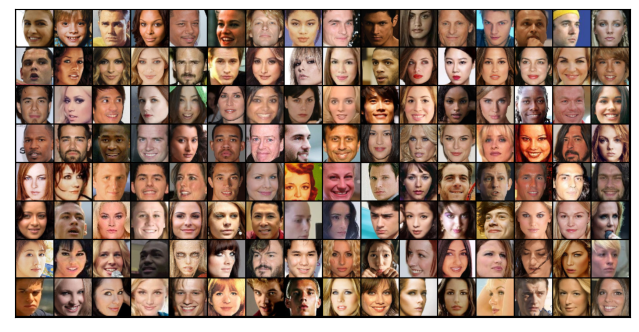

In [15]:
batchshow(dataloaders['train'])

# DCGAN Model

In [16]:
nc = 3 # number of channels in input images
nz = 100 # size of z latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh(),
            # (nc) x 64 x 64
        )
    
    def forward(self, x):
        return self.main(x)

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 1 x 1 x 1
        )

    def forward(self, x):
        return self.main(x)

# Train & Save

In [20]:
real_label = 1.0
fake_label = 0.0

In [21]:
fixed_noise_64 = torch.randn(64, nz, 1, 1, device=device)
fixed_noise_1000 = torch.randn(1000, nz, 1, 1, device=device)

In [22]:
def generate_fake_images(is_show=False, is_save=False, save_dir='./out_face/'):
    with torch.no_grad():
        if is_save == False:
            noise = fixed_noise_64
        else:
            noise = fixed_noise_1000
        fake_images = netG(noise).detach().cpu()
        fake_images = (fake_images + 1) / 2
        if is_show:
            fakeshow(fake_images)
        if is_save:
            for i in range(len(fake_images)):
                image = np.uint8(fake_images[i].permute(1, 2, 0) * 255)
                image = Image.fromarray(image)
                image.save('{}{:04d}.png'.format(save_dir, i), format='PNG')
    return fake_images

In [23]:
def save_fake_images(epoch, save_dir='./out1A/'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_dir = save_dir + str(epoch) + '/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    generate_fake_images(is_save=True, save_dir=save_dir)

In [24]:
def train(dataloaders, epochs, init_epoch=0, logfile='log.txt'):
    if init_epoch == 0:
        fout = open(logfile, 'w')
        fout.close()
    
    for epoch in range(epochs):
        if epoch == 0 and init_epoch != 0:
            continue

        for batch_idx, real_images in enumerate(dataloaders['train']):
            b_size = real_images.size(0)
            
            # ======================================================= #
            # update D network : maximize log(D(x)) + log(1 - D(G(z)) 
            # ======================================================= #
            netD.zero_grad()
            
            # real face images
            real_images = real_images.to(device)
            # labels for real face images
            y = torch.full((b_size,), real_label, device=device)
            # prediction for real face images
            y_out = netD(real_images).view(-1) # shape : [batch_size]
            errD_real = criterion(y_out, y)
            errD_real.backward()
            D_x = y_out.mean().item()

            # fake face images
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            # labels for fake face images
            y.fill_(fake_label)
            # prediction for fake face images
            y_out = netD(fake_images.detach()).view(-1) # shape : [batch_size]
            errD_fake = criterion(y_out, y)
            errD_fake.backward()
            D_G_z1 = y_out.mean().item()

            errD = errD_real + errD_fake

            optimizerD.step()

            # ======================================================= #
            # update G network : maximize log(D(G(z)))
            # ======================================================= #
            netG.zero_grad()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            # labels of fake images should be real for generator
            y.fill_(real_label)
            # prediction for fake face images
            y_out = netD(fake_images).view(-1)
            errG = criterion(y_out, y)
            errG.backward()
            D_G_z2 = y_out.mean().item()

            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())
                
            if batch_idx % 100 == 0:
                fout = open(logfile, 'a')
                fout.write('[%3d/%d][%5d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\n' % (
                    epoch + init_epoch, 
                    epochs + init_epoch - 1, 
                    batch_idx * len(images), 
                    len(dataloaders['train'].dataset), 
                    errD.item(), 
                    errG.item(), 
                    D_x, 
                    D_G_z1, 
                    D_G_z2,
                ))
                fout.close()

        save_fake_images(
            epoch=epoch,
            save_dir=save_img,
        )
        fr = face_recog('{}/{}'.format(save_img, epoch))
        fr_list.append(fr)
        fout = open(logfile, 'a')
        fout.write('\nface recognition rate = {:.2f}\n\n'.format(fr))
        fout.close()

        if epoch % 5 == 0:
        #     print('Epoch {}'.format(epoch))
            img_list.append([(epoch + init_epoch), generate_fake_images(is_show=False)])
            
        save_checkpoint(save_G + 'G-hw2p1A-%i.pth' % (epoch + init_epoch), netG, optimizerG)

    img_list.append([(epochs + init_epoch), generate_fake_images(is_show=False)])
    save_checkpoint(save_G + 'G-hw2p1A-%i.pth' % (epochs + init_epoch), netG, optimizerG)

In [25]:
save_G = './checkpoint/hw2p1A/final/'
save_log = './checkpoint/hw2p1A/'
save_img = './faceA_final/'

In [26]:
if not os.path.exists(save_G):
    os.makedirs(save_G)
if not os.path.exists(save_log):
    os.makedirs(save_log)
if not os.path.exists(save_img):
    os.makedirs(save_img)

In [27]:
img_list = []
G_losses = []
D_losses = []
fr_list = []

# Create Models

In [28]:
netD = Discriminator().to(device)
netD.apply(weights_init)
# print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [29]:
netG = Generator().to(device)
netG.apply(weights_init)
# print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [30]:
lrD = 0.0005
lrG = 0.005
beta1 = 0.5

In [31]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

# Start Training

In [32]:
log = save_log + 'log_hw2p1A_final.txt'
train(dataloaders, epochs=120, init_epoch=0, logfile=log)

100%|██████████| 1000/1000 [00:03<00:00, 280.00it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-0.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.29it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-1.pth


100%|██████████| 1000/1000 [00:03<00:00, 273.69it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-2.pth


100%|██████████| 1000/1000 [00:03<00:00, 279.10it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-3.pth


100%|██████████| 1000/1000 [00:03<00:00, 267.00it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-4.pth


100%|██████████| 1000/1000 [00:03<00:00, 275.18it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-5.pth


100%|██████████| 1000/1000 [00:03<00:00, 265.43it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-6.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.76it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-7.pth


100%|██████████| 1000/1000 [00:03<00:00, 267.69it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-8.pth


100%|██████████| 1000/1000 [00:03<00:00, 277.82it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-9.pth


100%|██████████| 1000/1000 [00:03<00:00, 264.72it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-10.pth


100%|██████████| 1000/1000 [00:03<00:00, 278.93it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-11.pth


100%|██████████| 1000/1000 [00:03<00:00, 265.90it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-12.pth


100%|██████████| 1000/1000 [00:03<00:00, 273.09it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-13.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.32it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-14.pth


100%|██████████| 1000/1000 [00:03<00:00, 276.21it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-15.pth


100%|██████████| 1000/1000 [00:03<00:00, 270.02it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-16.pth


100%|██████████| 1000/1000 [00:03<00:00, 277.93it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-17.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.48it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-18.pth


100%|██████████| 1000/1000 [00:03<00:00, 278.96it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-19.pth


100%|██████████| 1000/1000 [00:03<00:00, 272.89it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-20.pth


100%|██████████| 1000/1000 [00:03<00:00, 275.01it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-21.pth


100%|██████████| 1000/1000 [00:03<00:00, 262.67it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-22.pth


100%|██████████| 1000/1000 [00:03<00:00, 275.93it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-23.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.60it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-24.pth


100%|██████████| 1000/1000 [00:03<00:00, 273.51it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-25.pth


100%|██████████| 1000/1000 [00:03<00:00, 271.74it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-26.pth


100%|██████████| 1000/1000 [00:03<00:00, 276.17it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-27.pth


100%|██████████| 1000/1000 [00:03<00:00, 274.09it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-28.pth


100%|██████████| 1000/1000 [00:03<00:00, 279.10it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-29.pth


100%|██████████| 1000/1000 [00:03<00:00, 285.97it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-30.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.21it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-31.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.45it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-32.pth


100%|██████████| 1000/1000 [00:03<00:00, 298.79it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-33.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.30it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-34.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.71it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-35.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.24it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-36.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.79it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-37.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.43it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-38.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.99it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-39.pth


100%|██████████| 1000/1000 [00:03<00:00, 300.83it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-40.pth


100%|██████████| 1000/1000 [00:03<00:00, 295.52it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-41.pth


100%|██████████| 1000/1000 [00:03<00:00, 299.94it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-42.pth


100%|██████████| 1000/1000 [00:04<00:00, 215.57it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-43.pth


100%|██████████| 1000/1000 [00:03<00:00, 301.98it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-44.pth


100%|██████████| 1000/1000 [00:03<00:00, 311.39it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-45.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.07it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-46.pth


100%|██████████| 1000/1000 [00:03<00:00, 298.31it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-47.pth


100%|██████████| 1000/1000 [00:03<00:00, 292.33it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-48.pth


100%|██████████| 1000/1000 [00:03<00:00, 292.77it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-49.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.56it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-50.pth


100%|██████████| 1000/1000 [00:03<00:00, 295.13it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-51.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.91it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-52.pth


100%|██████████| 1000/1000 [00:03<00:00, 295.61it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-53.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.92it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-54.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.88it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-55.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.09it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-56.pth


100%|██████████| 1000/1000 [00:03<00:00, 310.93it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-57.pth


100%|██████████| 1000/1000 [00:03<00:00, 309.30it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-58.pth


100%|██████████| 1000/1000 [00:03<00:00, 309.80it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-59.pth


100%|██████████| 1000/1000 [00:03<00:00, 293.82it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-60.pth


100%|██████████| 1000/1000 [00:03<00:00, 312.19it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-61.pth


100%|██████████| 1000/1000 [00:04<00:00, 212.57it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-62.pth


100%|██████████| 1000/1000 [00:03<00:00, 307.49it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-63.pth


100%|██████████| 1000/1000 [00:04<00:00, 213.44it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-64.pth


100%|██████████| 1000/1000 [00:03<00:00, 314.55it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-65.pth


100%|██████████| 1000/1000 [00:03<00:00, 314.75it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-66.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.56it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-67.pth


100%|██████████| 1000/1000 [00:03<00:00, 311.59it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-68.pth


100%|██████████| 1000/1000 [00:03<00:00, 309.18it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-69.pth


100%|██████████| 1000/1000 [00:03<00:00, 297.63it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-70.pth


100%|██████████| 1000/1000 [00:03<00:00, 314.59it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-71.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.57it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-72.pth


100%|██████████| 1000/1000 [00:03<00:00, 296.42it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-73.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.23it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-74.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.18it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-75.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.81it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-76.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.53it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-77.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.07it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-78.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.81it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-79.pth


100%|██████████| 1000/1000 [00:03<00:00, 307.42it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-80.pth


100%|██████████| 1000/1000 [00:03<00:00, 292.54it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-81.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.63it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-82.pth


100%|██████████| 1000/1000 [00:04<00:00, 209.34it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-83.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.25it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-84.pth


100%|██████████| 1000/1000 [00:04<00:00, 217.72it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-85.pth


100%|██████████| 1000/1000 [00:03<00:00, 303.48it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-86.pth


100%|██████████| 1000/1000 [00:04<00:00, 217.32it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-87.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.58it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-88.pth


100%|██████████| 1000/1000 [00:04<00:00, 213.99it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-89.pth


100%|██████████| 1000/1000 [00:03<00:00, 305.29it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-90.pth


100%|██████████| 1000/1000 [00:04<00:00, 244.85it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-91.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.22it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-92.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.15it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-93.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.10it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-94.pth


100%|██████████| 1000/1000 [00:03<00:00, 300.60it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-95.pth


100%|██████████| 1000/1000 [00:03<00:00, 304.49it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-96.pth


100%|██████████| 1000/1000 [00:03<00:00, 310.33it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-97.pth


100%|██████████| 1000/1000 [00:03<00:00, 312.15it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-98.pth


100%|██████████| 1000/1000 [00:03<00:00, 308.55it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-99.pth


100%|██████████| 1000/1000 [00:03<00:00, 312.50it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-100.pth


100%|██████████| 1000/1000 [00:03<00:00, 315.39it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-101.pth


100%|██████████| 1000/1000 [00:03<00:00, 309.70it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-102.pth


100%|██████████| 1000/1000 [00:03<00:00, 306.86it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-103.pth


100%|██████████| 1000/1000 [00:04<00:00, 230.17it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-104.pth


100%|██████████| 1000/1000 [00:03<00:00, 294.90it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-105.pth


100%|██████████| 1000/1000 [00:03<00:00, 285.80it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-106.pth


100%|██████████| 1000/1000 [00:03<00:00, 294.65it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-107.pth


100%|██████████| 1000/1000 [00:04<00:00, 209.08it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-108.pth


100%|██████████| 1000/1000 [00:03<00:00, 250.38it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-109.pth


100%|██████████| 1000/1000 [00:04<00:00, 244.97it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-110.pth


100%|██████████| 1000/1000 [00:03<00:00, 252.48it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-111.pth


100%|██████████| 1000/1000 [00:03<00:00, 290.21it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-112.pth


100%|██████████| 1000/1000 [00:03<00:00, 281.71it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-113.pth


100%|██████████| 1000/1000 [00:03<00:00, 297.76it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-114.pth


100%|██████████| 1000/1000 [00:03<00:00, 302.31it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-115.pth


100%|██████████| 1000/1000 [00:03<00:00, 299.47it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-116.pth


100%|██████████| 1000/1000 [00:04<00:00, 229.02it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-117.pth


100%|██████████| 1000/1000 [00:03<00:00, 256.42it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-118.pth


100%|██████████| 1000/1000 [00:03<00:00, 257.28it/s]


model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-119.pth
model saved to ./checkpoint/hw2p1A/final/G-hw2p1A-120.pth


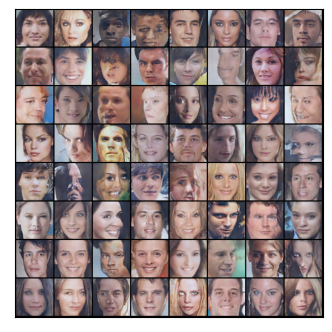

In [36]:
a = generate_fake_images(is_show=True)

# Info of Training

In [ ]:
# for i in range(len(img_list)):
#     print('Epoch {}'.format(img_list[i][0]))
#     fakeshow(img_list[i][1])

In [41]:
gif_dir = 'faceA_final_gif'
myFont = ImageFont.truetype('FreeMono.ttf', 20)
for i in range(0, int(120 / 5), 1):
    print('Epoch {}'.format(img_list[i][0]))
#     fakeshow(img_list[i][1])
    fake_images = img_list[i][1]
    image = np.uint8(make_grid(fake_images, nrow=8).permute(1, 2, 0) * 255)
    image = Image.fromarray(image)
    I1 = ImageDraw.Draw(image)
    I1.text((10, 50), 'Epoch {}'.format(i * 5), font=myFont, stroke_width=1, fill =(255, 0, 0))
    image.save('{}/{:03d}.png'.format(gif_dir, i * 5), format='PNG')

Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Epoch 50
Epoch 55
Epoch 60
Epoch 65
Epoch 70
Epoch 75
Epoch 80
Epoch 85
Epoch 90
Epoch 95
Epoch 100
Epoch 105
Epoch 110
Epoch 115


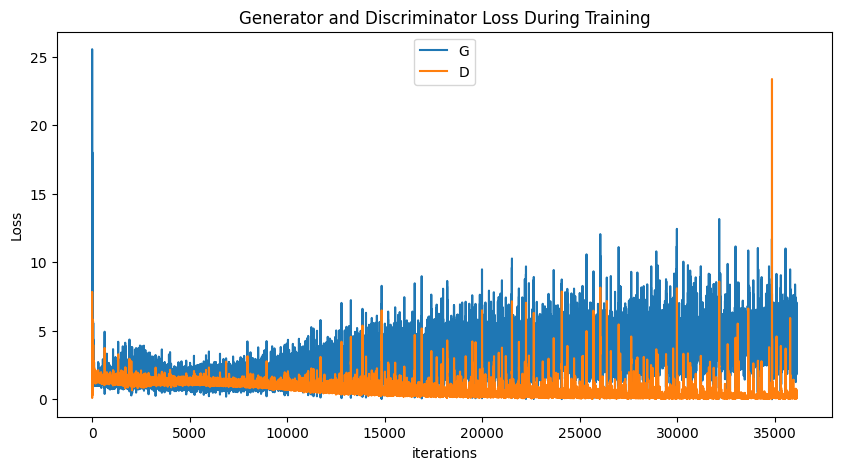

In [42]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Inference

In [44]:
netG = Generator().to(device)
optimizerG = optim.Adam(netG.parameters())
load_checkpoint('checkpoint/hw2p1A/final/G-hw2p1A-103.pth', netG, optimizerG)

model loaded from checkpoint/hw2p1A/final/G-hw2p1A-103.pth 


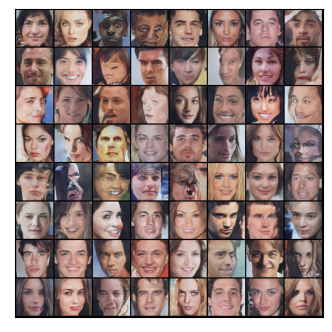

In [45]:
a = generate_fake_images(is_show=True)
myFont = ImageFont.truetype('FreeMono.ttf', 20)
#     fakeshow(img_list[i][1])
noise = fixed_noise_64
fake_images = netG(noise).detach().cpu()
fake_images = (fake_images + 1) / 2
image = np.uint8(make_grid(fake_images, nrow=8).permute(1, 2, 0) * 255)
image = Image.fromarray(image)
I1 = ImageDraw.Draw(image)
image.save('finalA.png', format='PNG')